In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class StockPricePredictor:
    def __init__(self, ticker='AAPL', start_date='2001-01-01', end_date='2024-01-01'):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.model = None

    def fetch_data(self):
        data = yf.download(self.ticker, start=self.start_date, end=self.end_date)

        features = ['Open', 'High', 'Low', 'Volume']
        target = 'Close'

        self.scaler_features = MinMaxScaler()
        self.scaler_target = MinMaxScaler()

        X = self.scaler_features.fit_transform(data[features])
        y = self.scaler_target.fit_transform(data[[target]])

        return X, y

    def create_sequences(self, X, y, look_back=2):
        X_seq, y_seq = [], []
        for i in range(len(X) - look_back):
            X_seq.append(X[i:(i+look_back)])
            y_seq.append(y[i+look_back])

        return np.array(X_seq), np.array(y_seq)

    def build_narx_model(self, input_shape, neurons=22):
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(neurons, input_shape=input_shape, return_sequences=False),
            tf.keras.layers.Dense(1, activation='linear')
        ])

        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        return model

    def train_model(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        self.model = self.build_narx_model(X_train.shape[1:])

        history = self.model.fit(
            X_train, y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            verbose=0
        )

        train_loss = self.model.evaluate(X_train, y_train, verbose=0)
        test_loss = self.model.evaluate(X_test, y_test, verbose=0)

        print(f"Train Loss: {train_loss}, Test Loss: {test_loss}")

        return history

    def predict(self, X):
        return self.scaler_target.inverse_transform(
            self.model.predict(X)
        )

    def plot_results(self, X, y):
        plt.figure(figsize=(15, 15))

        predictions = self.predict(X)
        actual = self.scaler_target.inverse_transform(y)

        plot_configs = [
            {'title': 'Actual vs Predicted Prices', 'y1': actual, 'y2': predictions},
            {'title': 'Regression Plot', 'y1': actual, 'y2': predictions},
            {'title': 'Errors', 'y1': actual - predictions}
        ]

        for i, config in enumerate(plot_configs, 1):
            plt.subplot(3, 1, i)
            plt.title(config['title'])

            if 'y2' in config:
                plt.plot(actual, label='Actual', color='blue')
                plt.plot(predictions, label='Predicted', color='red', alpha=0.7)
                plt.legend()
            else:
                plt.plot(config['y1'], color='green')
                plt.axhline(y=0, color='red', linestyle='--')

        plt.tight_layout()
        plt.show()

    def run_analysis(self):
        X, y = self.fetch_data()
        X_seq, y_seq = self.create_sequences(X, y)

        history = self.train_model(X_seq, y_seq)
        self.plot_results(X_seq, y_seq)

        return history

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train Loss: [6.014202517690137e-05, 0.004057381302118301], Test Loss: [5.837247590534389e-05, 0.003988008946180344]
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


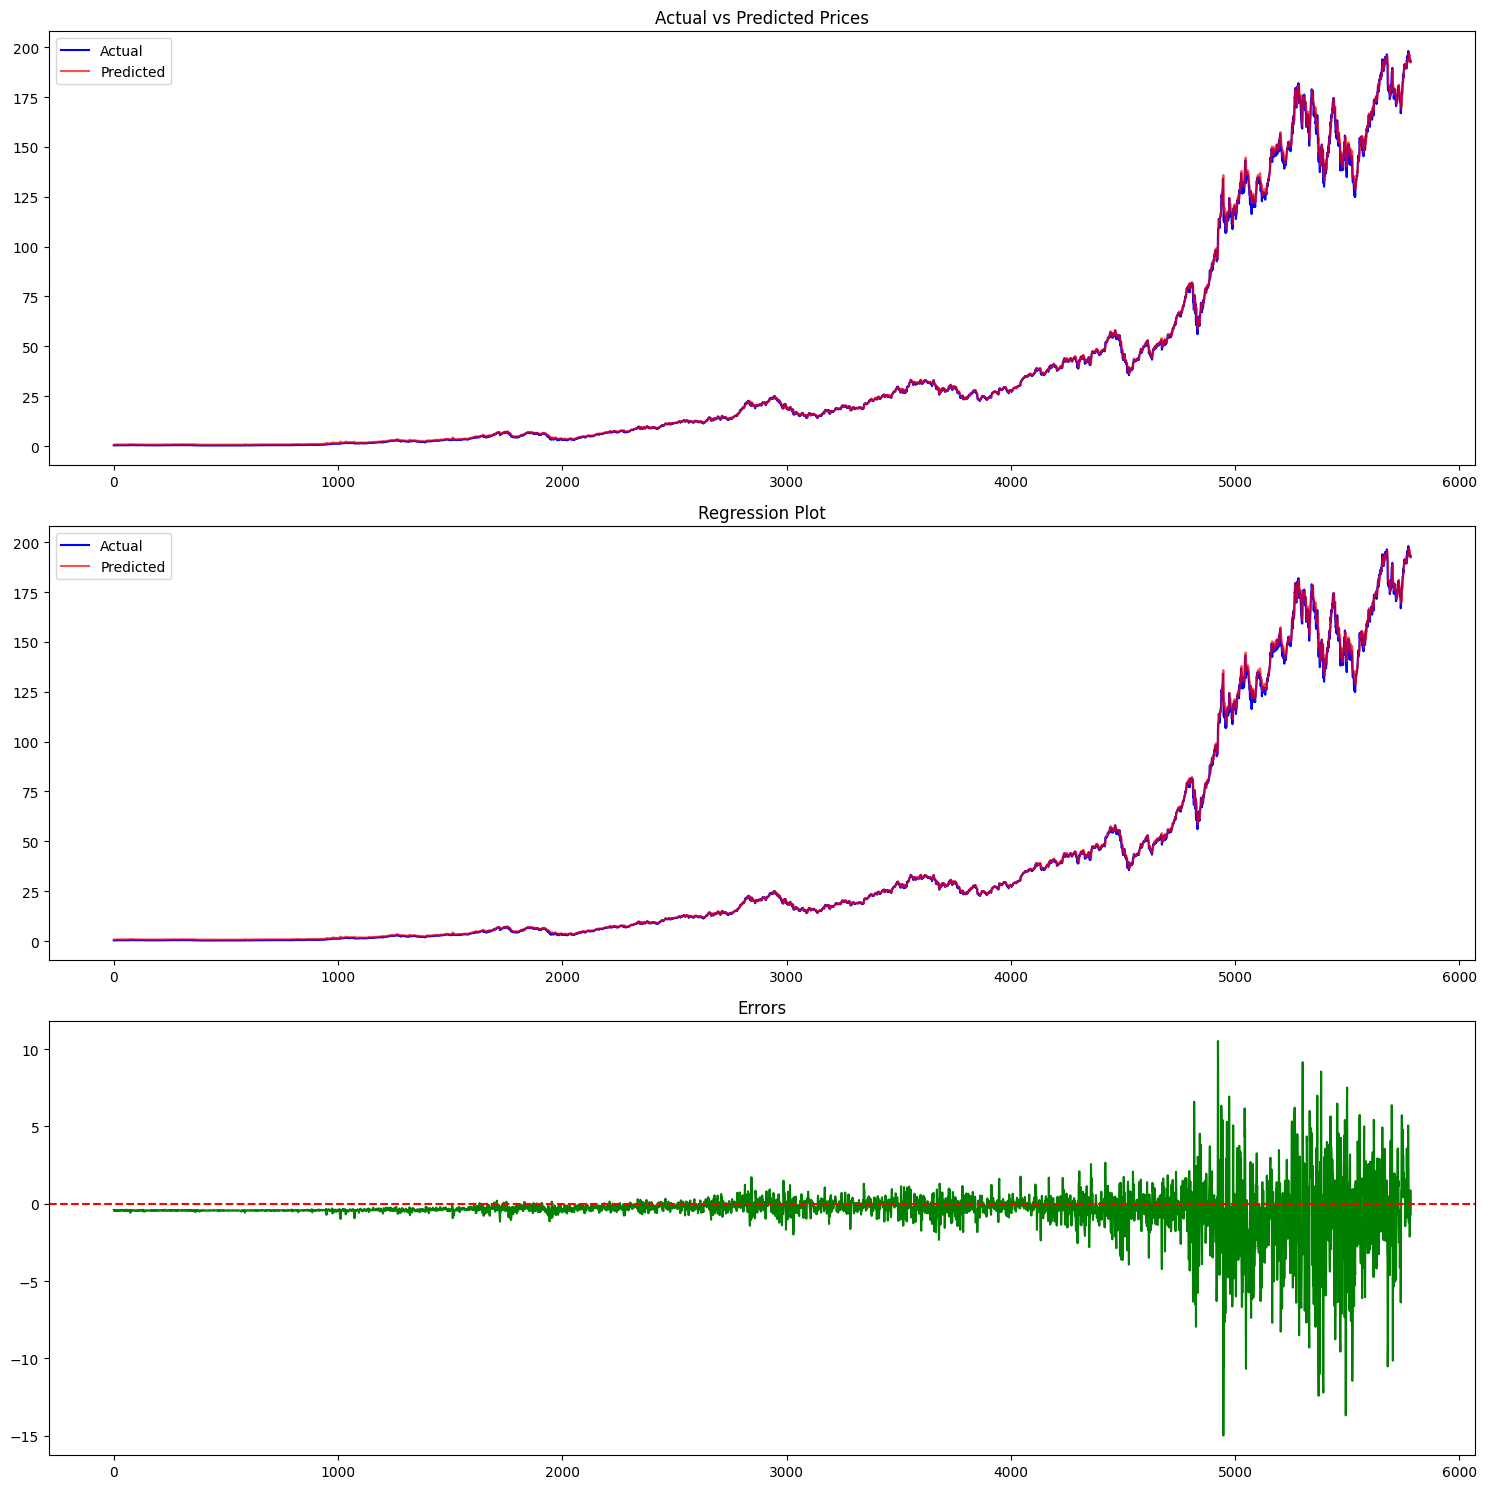

In [3]:
predictor = StockPricePredictor()
predictor.run_analysis()